In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


surrogate_path = '../surrogate/routes_short_2023-06-18|14:50:15/'

In [11]:
scenario_header = ["cloudiness",
                   "precipitation",
                   "precipitation_deposits",
                   "wind_intensity",
                   "sun_azimuth_angle",
                   "sun_altitude_angle",
                   "fog_density",
                   "wetness",
                   "fog_falloff",
                   "vehicle_infront", 
                   "vehicle_opposite", 
                   "vehicle_side",
                   "start_offset",
                   "end_offset"]
surrogate_scenarios = pd.read_csv(surrogate_path+'scenario.csv',names=scenario_header)
surrogate_criterion = pd.read_csv(surrogate_path+'criterion.csv',names= ['OutsideRouteLanesTest','CollisionTest','RouteCompletionTest'])
surrogate_frontier_scenarios = np.load(surrogate_path+'output.npz')['arr_0']
surrogate_frontier_criterion = np.load(surrogate_path+'output.npz')['arr_1']

print(surrogate_scenarios.shape)
print(surrogate_criterion.shape)
print(surrogate_frontier_scenarios.shape)
print(surrogate_frontier_criterion.shape)

(15040, 14)
(15040, 3)
(50, 14)
(50, 3)


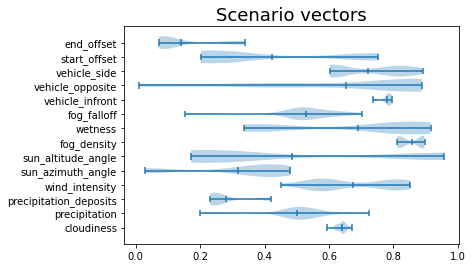

In [12]:
plt.violinplot(surrogate_frontier_scenarios, vert=False, showmeans=True, widths=0.9)
plt.yticks(range(1,15), scenario_header)
plt.title("Scenario vectors", fontsize=18)
plt.show()

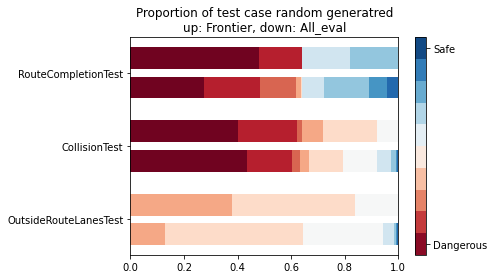

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt

cmap = mpl.cm.RdBu
colors = cmap(range(3,253,25))

stack_hist_continuous = np.concatenate([
    [np.histogram(surrogate_frontier_criterion[:,0], range=(0,1), bins=10)[0]/surrogate_frontier_criterion.shape[0]],
    [np.histogram(surrogate_frontier_criterion[:,1], range=(0,1), bins=10)[0]/surrogate_frontier_criterion.shape[0]],
    [np.histogram(surrogate_frontier_criterion[:,2], range=(0,1), bins=10)[0]/surrogate_frontier_criterion.shape[0]],
])

left = np.zeros(3)
for i in range(10):
    plt.barh(y = np.arange(3)+0.2, width = stack_hist_continuous[:,i], left=left, color = colors[i], height=0.3)
    left += stack_hist_continuous[:,i]

stack_hist_continuous = np.concatenate([
    [np.histogram(surrogate_criterion['OutsideRouteLanesTest'], range=(0,1), bins=10)[0]/surrogate_criterion.shape[0]],
    [np.histogram(surrogate_criterion['CollisionTest'],         range=(0,1), bins=10)[0]/surrogate_criterion.shape[0]],
    [np.histogram(surrogate_criterion['RouteCompletionTest'],   range=(0,1), bins=10)[0]/surrogate_criterion.shape[0]],
])

left = np.zeros(3)
for i in range(10):
    plt.barh(y = np.arange(3)-0.2, width = stack_hist_continuous[:,i], left=left, color = colors[i], height=0.3)
    left += stack_hist_continuous[:,i]

plt.yticks(range(3), ['OutsideRouteLanesTest','CollisionTest','RouteCompletionTest'])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ticklocation='right',values=range(10), ticks=[0, 9])
cbar.ax.set_yticklabels(['Dangerous', 'Safe'])  # vertically oriented colorbar

plt.title('Proportion of test case random generatred\nup: Frontier, down: All_eval')
plt.show()

Pymoo checkpoint

In [3]:
import joblib
import dill
import numpy as np

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.termination import get_termination
from pymoo.termination.max_gen import MaximumGenerationTermination


In [4]:
class SurrogateProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=14,
                         n_obj=3,
                         xl=np.zeros(14),
                         xu=np.ones(14))
        

    def _evaluate(self, x, out, *args, **kwargs):
        # model_path = './tools/models/'
        model_path = '../tools/models/regression-HGB'
        surrogate_models = {"RouteCompletionTest"  : joblib.load(model_path+'-RouteCompletionTest.pkl'), 
                            "CollisionTest"        : joblib.load(model_path+'-CollisionTest.pkl'), 
                            "OutsideRouteLanesTest": joblib.load(model_path+'-OutsideRouteLanesTest.pkl'), 
                            "Timeout"              : joblib.load(model_path+'-Timeout.pkl')}
        result = np.array([
            surrogate_models["OutsideRouteLanesTest"].predict([x])[0],
            surrogate_models["CollisionTest"].predict([x])[0],
            surrogate_models["RouteCompletionTest"].predict([x])[0]
        ])
        result[result>1] = 1
        result[result<0] = 0

        out['F'] = result

In [11]:
pop_size = 2
n_offsprings = 2
generations = 2

problem = SurrogateProblem()
algorithm = NSGA2(
    pop_size=pop_size,
    n_offsprings=n_offsprings,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
    seed=1,
    copy_algorithm=False,
    # save_history=True,
    verbose=True
)

# algorithm.setup(problem, seed=1, termination=('n_gen', generations))

# i = 0
# save_step = 5
# while algorithm.has_next():
#     algorithm.next()
#     print(algorithm.n_gen)
#     if i % save_step == save_step:
#         with open("./ckpt/checkpoint-{}.ckpt".format(i), "wb") as f:
#             dill.dump(algorithm, f)
#     i += 1



In [12]:
# termination = get_termination("n_gen", 5)

res = minimize(problem,
    algorithm,
     ('n_gen', generations),
    seed=1,
    copy_algorithm=False,
    # save_history=True,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        2 |      1 |             - |             -
     2 |        4 |      2 |  1.0000000000 |         ideal
     3 |        6 |      2 |  0.9456398965 |         ideal
     4 |        8 |      2 |  1.0000000000 |         ideal
     5 |       10 |      1 |  0.0063884049 |         ideal


In [13]:
with open("./ckpt/checkpoint-0.ckpt", "wb") as f:
    dill.dump(algorithm, f)

In [15]:
with open("./ckpt/checkpoint-{}.ckpt".format(0), 'rb') as f:
    checkpoint = dill.load(f)
    print("Loaded Checkpoint:", checkpoint)

# checkpoint.termination = get_termination("n_gen", 5)

# res = minimize(problem,
#     checkpoint,
#     seed=1,
#     copy_algorithm=False,
#     save_history=True,
#     verbose=True
# )

# res = minimize(problem,
#                checkpoint,
#                ("n_gen", 5),
#                seed=1,
#                copy_algorithm=False,
#                verbose=True)

Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7fdd80b62310>


In [18]:
checkpoint.result().X

array([[0.03142452, 0.58365418, 0.4173048 , 0.55868983, 0.14038694,
        0.19810149, 0.80074457, 0.92562873, 0.36994726, 0.69232262,
        0.83017517, 0.89460666, 0.08504421, 0.03905478]])

In [9]:
for i in range(1, 2):

    checkpoint = None

    with open("./ckpt/checkpoint-{}.ckpt".format(i-1), 'rb') as f:
        checkpoint = dill.load(f)
        print("Loaded Checkpoint:", checkpoint)

    checkpoint.termination = MaximumGenerationTermination(5)

    res = minimize(problem,
        checkpoint,
        ('n_gen', 5),
        seed=1,
        copy_algorithm=False,
        save_history=True,
        verbose=True
    )

    with open("./ckpt/checkpoint-{}.ckpt".format(i), "wb") as f:
        dill.dump(algorithm, f)


Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f5854afc290>
     6 |      100 |     10 |  0.0509169280 |             f
Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f585535e690>
     6 |      100 |     10 |  0.0030391276 |         ideal
Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f58557b11d0>
     6 |      100 |     12 |  0.2911493876 |         nadir
Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f585522d390>
     6 |      100 |     11 |  0.0825634045 |             f
Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f5854cd8a10>
     6 |      100 |     11 |  0.0281538760 |             f
Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f58556f4c50>
     6 |      100 |     11 |  0.0477638699 |         ideal
Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f58558370d0>
     6 |      100 |     11 |  0.0431634099 |             f
Loaded Checkpoint: <pymoo.algorith

KeyboardInterrupt: 

In [21]:
import dill
from pymoo.problems import get_problem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination.max_gen import MaximumGenerationTermination

problem = get_problem("zdt1", n_var=5)

algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 5),
               seed=1,
               copy_algorithm=False,
               verbose=True)

with open("checkpoint", "wb") as f:
    dill.dump(algorithm, f)

with open("checkpoint", 'rb') as f:
    checkpoint = dill.load(f)
    print("Loaded Checkpoint:", checkpoint)

# only necessary if for the checkpoint the termination criterion has been met
checkpoint.termination = MaximumGenerationTermination(20)

res = minimize(problem,
               checkpoint,
               seed=1,
               copy_algorithm=False,
               verbose=True)

ValueError: operands could not be broadcast together with shapes (2,) (3,) 